In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas()
import gc
import lightgbm as lgb
gc.collect()

0

In [3]:
df_train_vrd_rel = pd.read_hdf('vrd/temp/df_train_vrd_rel.h5', 'df_train_vrd_rel')
df_valid_vrd_rel = pd.read_hdf('vrd/temp/df_valid_vrd_rel.h5', 'df_valid_vrd_rel')
df_test_rel = pd.read_hdf('vrd/temp/df_test_rel.h5', 'df_test_rel')

## 1. Train Relationship Model

### 1.1 Prepare Features

In [4]:
def computeAspectRatio1(row):
    return (row["XMax1"]-row["XMin1"])/(row["YMax1"]-row["YMin1"])

def computeAspectRatio2(row):
    return (row["XMax2"]-row["XMin2"])/(row["YMax2"]-row["YMin2"])

def computeSize1(row):
    return (row["XMax1"]-row["XMin1"])*(row["YMax1"]-row["YMin1"])

def computeSize2(row):
    return (row["XMax2"]-row["XMin2"])*(row["YMax2"]-row["YMin2"])

def computeCenterX1(row):
    return (row["XMax1"]-row["XMin1"])/2+row["XMin1"]

def computeCenterX2(row):
    return (row["XMax2"]-row["XMin2"])/2+row["XMin2"]

def computeCenterY1(row):
    return (row["YMax1"]-row["YMin1"])/2+row["YMin1"]

def computeCenterY2(row):
    return (row["YMax2"]-row["YMin2"])/2+row["YMin2"]

def computeCenterXDiff(row):
  # return row["CenterX1"]-row["CenterX2"]
    return computeCenterX1(row)-computeCenterX2(row)

def computeCenterYDiff(row):
    return computeCenterY1(row)-computeCenterY2(row)
  # return row["CenterY1"]-row["CenterY2"]

def computeCenterDiff(row):
    return (computeCenterXDiff(row)**2+computeCenterYDiff(row)**2)**0.5

def computeCenterX(row):
    return (computeCenterX1(row)+computeCenterX2(row))/2

def computeCenterY(row):
    return (computeCenterY1(row)+computeCenterY2(row))/2

def computeIOU(row):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(row["XMin1"], row["XMin2"])
    yA = max(row["YMin1"], row["YMin2"])
    xB = min(row["XMax1"], row["XMax2"])
    yB = min(row["YMax1"], row["YMax2"])

    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (row["XMax1"] - row["XMin1"] + 1) * (row["YMax1"] - row["YMin1"]  + 1)
    boxBArea = (row["XMax2"] - row["XMin2"]  + 1) * (row["YMax2"] - row["YMin2"] + 1)

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)

    # return the intersection over union value
    return iou


def add_features(df):
    df["AspectRatio1"] = df.progress_apply(lambda row: computeAspectRatio1(row), axis=1)
    df["AspectRatio2"] = df.progress_apply(lambda row: computeAspectRatio2(row), axis=1)

    df["Size1"] = df.progress_apply(lambda row: computeSize1(row), axis=1)
    df["Size2"] = df.progress_apply(lambda row: computeSize2(row), axis=1)

    df["CenterX1"] = df.progress_apply(lambda row: computeCenterX1(row), axis=1)
    df["CenterX2"] = df.progress_apply(lambda row: computeCenterX2(row), axis=1)
    df["CenterY1"] = df.progress_apply(lambda row: computeCenterY1(row), axis=1)
    df["CenterY2"] = df.progress_apply(lambda row: computeCenterY2(row), axis=1)

    df["XCenterDiff"] = df.progress_apply(lambda row: computeCenterXDiff(row), axis=1)
    df["YCenterDiff"] = df.progress_apply(lambda row: computeCenterYDiff(row), axis=1)

    df["CenterDiff"] = df.progress_apply(lambda row: computeCenterDiff(row), axis=1)
    df["CenterX"] = df.progress_apply(lambda row: computeCenterX(row), axis=1)
    df["CenterY"] = df.progress_apply(lambda row: computeCenterY(row), axis=1)

    df["IOU"] = df.progress_apply(lambda row: computeIOU(row), axis=1)


In [7]:
add_features(df_train_vrd_rel)
print("VALIDATION")
add_features(df_valid_vrd_rel)
# print("TEST")
# add_features(df_test_rel)

  0%|          | 0/1418 [00:00<?, ?it/s]

VALIDATION


100%|██████████| 1418/1418 [00:00<00:00, 4317.53it/s]


In [8]:
df_train_vrd_rel.to_hdf('vrd/df_train_vrd_rel_features.h5', key='df_train_vrd_rel', mode='w', format='t')
df_valid_vrd_rel.to_hdf('vrd/df_valid_vrd_rel_features.h5', key='df_valid_vrd_rel', mode='w', format='t')
# df_test_rel.to_hdf('vrd/df_test_rel_features.h5', key='df_test_rel', mode='w', format='t')

In [15]:
df_test_rel.to_hdf('vrd/temp/df_test_rel_features.h5', key='df_test_rel', mode='w', format='t')

### 1.2 Load Features

In [5]:
df_train_vrd_rel = pd.read_hdf('vrd/df_train_vrd_rel_features.h5', 'df_train_vrd_rel')
df_valid_vrd_rel = pd.read_hdf('vrd/df_valid_vrd_rel_features.h5', 'df_valid_vrd_rel')
df_test_rel = pd.read_hdf('vrd/temp/df_test_rel_features.h5', 'df_test_rel') 

In [6]:
drop_cols = ["XMin1", "XMax1", "YMin1", "YMax1", "XMin2", "XMax2", "YMin2", "YMax2"]
X_train = df_train_vrd_rel.drop(drop_cols+['ImageID','RelationshipLabel'], axis=1)
y_train = df_train_vrd_rel['RelationshipLabel'].cat.codes 
X_valid = df_valid_vrd_rel.drop(drop_cols+['ImageID','RelationshipLabel'], axis=1)
y_valid = df_valid_vrd_rel['RelationshipLabel'].cat.codes # pd.get_dummies(df_valid_vrd_rel['RelationshipLabel']).values

In [7]:
X_test = df_test_rel.drop(drop_cols+['ImageID','Confidence1','Confidence2','RelationshipLabel'], axis=1)

In [8]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_valid = lgb.Dataset(X_valid, y_valid)

In [12]:
params = {
        'objective': 'multiclass',
        'boosting': 'gbdt',
        'learning_rate': 0.002 ,
        'verbose': 0,
        'num_leaves': 100,
        'bagging_fraction': 0.95,
        'bagging_freq': 1,
        'bagging_seed': 1,
        'feature_fraction': 0.9,
        'feature_fraction_seed': 1,
        'max_bin': 256,
        'num_rounds': 10000,
        'metric': ['multi_logloss','map'],
        'num_class': 9
    }
cats_dict = dict( zip( df_valid_vrd_rel['RelationshipLabel'].cat.codes, df_valid_vrd_rel['RelationshipLabel'] ) )

In [14]:
lgbm_model = lgb.train(params, train_set = lgb_train, valid_sets = lgb_valid, verbose_eval=5, early_stopping_rounds=5)

/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 5 rounds.
[5]	valid_0's multi_logloss: 1.58063
[10]	valid_0's multi_logloss: 1.53692
[15]	valid_0's multi_logloss: 1.4994
[20]	valid_0's multi_logloss: 1.46482
[25]	valid_0's multi_logloss: 1.4354
[30]	valid_0's multi_logloss: 1.40783
[35]	valid_0's multi_logloss: 1.38083
[40]	valid_0's multi_logloss: 1.35424
[45]	valid_0's multi_logloss: 1.33113
[50]	valid_0's multi_logloss: 1.30766
[55]	valid_0's multi_logloss: 1.28641
[60]	valid_0's multi_logloss: 1.26544
[65]	valid_0's multi_logloss: 1.24601
[70]	valid_0's multi_logloss: 1.22774
[75]	valid_0's multi_logloss: 1.20926
[80]	valid_0's multi_logloss: 1.19045
[85]	valid_0's multi_logloss: 1.17209
[90]	valid_0's multi_logloss: 1.15513
[95]	valid_0's multi_logloss: 1.13879
[100]	valid_0's multi_logloss: 1.12238
[105]	valid_0's multi_logloss: 1.10709
[110]	valid_0's multi_logloss: 1.09288
[115]	valid_0's multi_logloss: 1.07827
[120]	valid_0's multi_logloss: 1.06442
[125]	valid_0's multi_log

[1030]	valid_0's multi_logloss: 0.258884
[1035]	valid_0's multi_logloss: 0.257742
[1040]	valid_0's multi_logloss: 0.256476
[1045]	valid_0's multi_logloss: 0.255239
[1050]	valid_0's multi_logloss: 0.253996
[1055]	valid_0's multi_logloss: 0.252755
[1060]	valid_0's multi_logloss: 0.251528
[1065]	valid_0's multi_logloss: 0.250335
[1070]	valid_0's multi_logloss: 0.249113
[1075]	valid_0's multi_logloss: 0.247888
[1080]	valid_0's multi_logloss: 0.246711
[1085]	valid_0's multi_logloss: 0.245525
[1090]	valid_0's multi_logloss: 0.244361
[1095]	valid_0's multi_logloss: 0.243267
[1100]	valid_0's multi_logloss: 0.242164
[1105]	valid_0's multi_logloss: 0.241116
[1110]	valid_0's multi_logloss: 0.240012
[1115]	valid_0's multi_logloss: 0.238942
[1120]	valid_0's multi_logloss: 0.23785
[1125]	valid_0's multi_logloss: 0.23678
[1130]	valid_0's multi_logloss: 0.235762
[1135]	valid_0's multi_logloss: 0.23478
[1140]	valid_0's multi_logloss: 0.233728
[1145]	valid_0's multi_logloss: 0.232694
[1150]	valid_0's mu

[2035]	valid_0's multi_logloss: 0.145372
[2040]	valid_0's multi_logloss: 0.145186
[2045]	valid_0's multi_logloss: 0.144988
[2050]	valid_0's multi_logloss: 0.144812
[2055]	valid_0's multi_logloss: 0.144631
[2060]	valid_0's multi_logloss: 0.144437
[2065]	valid_0's multi_logloss: 0.144264
[2070]	valid_0's multi_logloss: 0.144081
[2075]	valid_0's multi_logloss: 0.143916
[2080]	valid_0's multi_logloss: 0.14375
[2085]	valid_0's multi_logloss: 0.14357
[2090]	valid_0's multi_logloss: 0.14339
[2095]	valid_0's multi_logloss: 0.14322
[2100]	valid_0's multi_logloss: 0.143043
[2105]	valid_0's multi_logloss: 0.142886
[2110]	valid_0's multi_logloss: 0.142738
[2115]	valid_0's multi_logloss: 0.142561
[2120]	valid_0's multi_logloss: 0.14241
[2125]	valid_0's multi_logloss: 0.142238
[2130]	valid_0's multi_logloss: 0.142064
[2135]	valid_0's multi_logloss: 0.141906
[2140]	valid_0's multi_logloss: 0.141755
[2145]	valid_0's multi_logloss: 0.1416
[2150]	valid_0's multi_logloss: 0.141426
[2155]	valid_0's multi_

[3040]	valid_0's multi_logloss: 0.128466
[3045]	valid_0's multi_logloss: 0.128436
[3050]	valid_0's multi_logloss: 0.128408
[3055]	valid_0's multi_logloss: 0.128381
[3060]	valid_0's multi_logloss: 0.128365
[3065]	valid_0's multi_logloss: 0.128347
[3070]	valid_0's multi_logloss: 0.128323
[3075]	valid_0's multi_logloss: 0.128303
[3080]	valid_0's multi_logloss: 0.128275
[3085]	valid_0's multi_logloss: 0.128253
[3090]	valid_0's multi_logloss: 0.128235
[3095]	valid_0's multi_logloss: 0.128207
[3100]	valid_0's multi_logloss: 0.12819
[3105]	valid_0's multi_logloss: 0.128167
[3110]	valid_0's multi_logloss: 0.128148
[3115]	valid_0's multi_logloss: 0.128126
[3120]	valid_0's multi_logloss: 0.128104
[3125]	valid_0's multi_logloss: 0.128084
[3130]	valid_0's multi_logloss: 0.128061
[3135]	valid_0's multi_logloss: 0.128044
[3140]	valid_0's multi_logloss: 0.128017
[3145]	valid_0's multi_logloss: 0.127989
[3150]	valid_0's multi_logloss: 0.127958
[3155]	valid_0's multi_logloss: 0.127941
[3160]	valid_0's 

In [16]:
lgbm_model.save_model('model.txt')

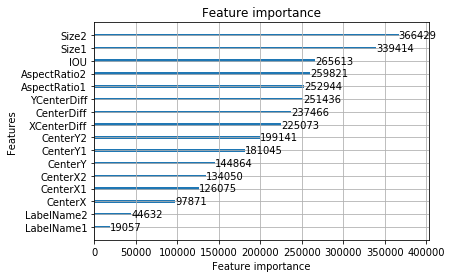

In [20]:
lgb.plot_importance(lgbm_model)

### 1.3 Evaluate

In [9]:
lgbm_model = lgb.Booster(model_file='model.txt')  # init model

In [10]:
batch_size = 1000
len(X_test)

3601704

In [13]:
for i in tqdm(range(0,len(X_test),batch_size)):
    total_batch_size = min(i+batch_size, len(X_test))
    predictions = lgbm_model.predict(X_test[i:total_batch_size], num_iteration=lgbm_model.best_iteration)
    predict_rel_label = predictions.argmax(axis=1)
    cat_pred_rel_label = [cats_dict[x] for x in predict_rel_label]
    df_test_rel[i:total_batch_size]["RelationshipLabel"] = cat_pred_rel_label

  0%|          | 0/3602 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
100%|██████████| 3602/3602 [47:41<00:00,  1.38it/s]


### 1.4 THIS IS WHAT WE WANT WHEN WE COMBINE

In [28]:
df_test_rel.to_csv("submission_rel.csv",index=False)

### 1.5 Individual Submission

In [14]:
list_imgids = list(df_test_rel['ImageID'].unique())

In [15]:
df_group = df_test_rel.groupby('ImageID')

In [18]:
final_sub = []
i=0
for image_id in tqdm(list_imgids):
    gp = df_test_rel[df_test_rel['ImageID']==image_id]
    predStr = ""
    for index, row in gp.iterrows():
        confidence = (row["Confidence1"] + row["Confidence2"])/2
        label1 = row["LabelName1"]
        XMin1, YMin1, XMax1, YMax1 = row["XMin1"], row["YMin1"], row["XMax1"], row["YMax1"] 
        label2 = row["LabelName2"]
        XMin2, YMin2, XMax2, YMax2 = row["XMin2"], row["YMin2"], row["XMax2"], row["YMax2"] 
        relLabel = row["RelationshipLabel"]
        predStr += str(confidence) + " " + str(label1) + " " + \
          str(XMin1) + " "+ str(YMin1) + " " + str(XMax1) + " "+ str(YMax1) + " " + \
          str(label2) + " " + \
          str(XMin2) + " "+ str(YMin2) + " " + str(XMax2) + " "+ str(YMax2) + " " + \
          str(relLabel) + " "
    dict_res = {
      "ImageId": image_id,
      "PredictionString": predStr,
    }
    final_sub.append(dict_res)
    i+=1

100%|██████████| 47727/47727 [3:58:05<00:00,  3.52it/s]  


In [19]:
len(final_sub)

47727

In [20]:
df_bbox_submission = pd.read_csv("submission.csv")


KeyError: 'ImageID'

In [21]:
list_test_imageIds = df_bbox_submission["ImageId"].values

In [22]:
df_submit = pd.DataFrame(final_sub)

In [23]:
list_predicted_imgs = df_submit.ImageId.values
main_list = list(set(list_test_imageIds) - set(list_predicted_imgs))
len(main_list)

52272

In [24]:
append_unpredicted = []
for ml in main_list:
    append_unpredicted.append({
      "ImageId":ml,
      "PredictionString":""
    })
df_append = pd.DataFrame(append_unpredicted)

In [25]:
df_final = pd.concat([df_submit, df_append], ignore_index=True, sort =False)

In [26]:
df_final.head()

,ImageId,PredictionString
0,00000b4dcff7f799,0.2998027503490448 /m/04yx4 0.86089194 0.30551...
1,00001a21632de752,0.45690925419330597 /m/03bt1vf 0.5485642 0.598...
2,0001dd930912683d,0.4464254043996334 /m/04yx4 0.72589636 0.08864...
3,0002f94fe2d2eb9f,0.004397584241814911 /m/04yx4 0.18545882 0.0 0...
4,0003d1c3be9ed3d6,0.42891743453219533 /m/04yx4 0.5961155 0.10516...


In [27]:
df_final.to_csv("vrd_submission.csv", index=False)